[4.137, -14.087, 5.048, -14.932, -14.23, -9.064, 4.478, -37.305, 0.341, -7.894, -5.78]


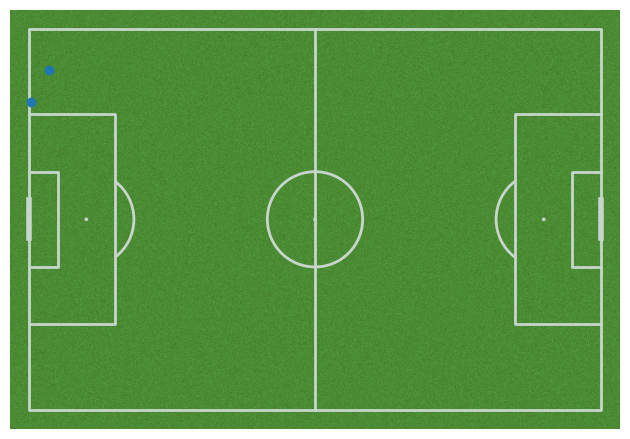

In [ ]:
# from mplsoccer.pitch import Pitch
# import json 

# with open('./FIFA_WorldCup_2022/Event Data/3813.json','r') as f:
#     data = json.load(f)
# home_team = data[0]["homePlayers"]

# pitch = Pitch(pitch_type='statsbomb',
#               pitch_color='grass', line_color='#c7d5cc')
# fig, ax = pitch.draw()

# x = []
# y = []
# for player in home_team:
#     x.append(player['x'])
#     y.append(player['y'])


# print(x)

# _ = pitch.scatter(x, y, ax=ax)

In [1]:
!pip install polars -q

il mio tool di labeling deve vedere teoricamente due cose:
- il campo come mplsoccer (a sinistra)
- il frame del video come una sorta di controllo visuale per vedere se tutto torna nella visualizzazione a sinistra (a destra)

intanto procedo a costruire un polar dataframe che mi permetterà di ciclare tra gli eventi efficientemente

In [2]:
!ffmpeg -i "https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1210.777" \
       -ss 1210.777 \
       -frames:v 1 frame.png

ffmpeg version 7.0.2-3ubuntu1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14 (Ubuntu 14.2.0-2ubuntu1)
  configuration: --prefix=/usr --extra-version=3ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-libmfx --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enab

[in#0 @ 0x5c1f9faa4f40] Error opening input: Invalid data found when processing input
Error opening input file https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1210.777.
Error opening input files: Invalid data found when processing input


In [1]:
import os
from typing import Tuple, Dict, Any, List
import polars as pl
import json

In [2]:
def extract_event(event: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "gameId": event["gameId"],
        "gameEventId": event["gameEventId"],
        "possessionEventId": event["possessionEventId"],
        "startTime": event["startTime"],
        "endTime": event["endTime"],
        "duration": event["duration"],
        "gameEventType": event["gameEvents"]["gameEventType"],
        "possessionEventType": event["possessionEvents"]["possessionEventType"],
        "teamName": event["gameEvents"]["teamName"],
        "playerName": event["gameEvents"]["playerName"],
        "videoUrl": event["gameEvents"]["videoUrl"],
        "label" : None
    }
    # grades può essere utile?
    # fouls può essere utile?
    # nei possession events sembrano ci siano dati molto interessanti
    # soprattuto nel caso della ball pass prediction
    # come l'accuratezza del tiro etc


def extract_players(event: Dict[str, Any]) -> List[Dict[str, Any]]:
    # metto tutti i giocatori in un dataframe a parte, 
    # uso come chiave esterna (gameId e gameEventId)
    players = []
    for player in event["homePlayers"]:
        players.append({
            "gameId": event["gameId"],
            "gameEventId": event["gameEventId"],
            "jerseyNum": player["jerseyNum"],
            "x": player["x"],
            "y": player["y"],
            "z": 0.,
            "team": "home"
        })    
    for player in event["awayPlayers"]:
        players.append({
            "gameId": event["gameId"],
            "gameEventId": event["gameEventId"],
            "jerseyNum": player["jerseyNum"],
            "x": player["x"],
            "y": player["y"],
            "z": 0,
            "team": "away"
        })
    ball = event["ball"]
    players.append({
        "gameId": event["gameId"],
        "gameEventId": event["gameEventId"],
        "jerseyNum": None,
        "x": ball["x"],
        "y": ball["y"],
        "z": ball["z"],
        "team": None
    })
    return players


def load_and_process_soccer_events(event_dir_path: str) -> Tuple[pl.DataFrame, pl.DataFrame]:
    event_files = [f for f in os.listdir(event_dir_path) if f.endswith('.json')]

    all_events = []
    all_players = []
    for event_file in event_files:
        with open(os.path.join(event_dir_path, event_file), 'r') as f:
            data = json.load(f)

        for e in data:
            if e['homePlayers'] is None or\
               e['awayPlayers'] is None or\
               e['ball'] is None or\
               e['gameEvents']['gameEventType'] == 'OUT':
                continue

            all_events.append(extract_event(e))
            all_players.extend(extract_players(e))

    event_df = pl.DataFrame(all_events).with_row_index()
    players_df = pl.DataFrame(all_players).with_row_index()

    return event_df, players_df


event_df, players_df = load_and_process_soccer_events('./FIFA_WorldCup_2022/Event Data/')
print("Events DataFrame:")
print(event_df)
print("\nPlayers DataFrame:")
print(players_df)

Events DataFrame:
shape: (84_685, 13)
┌───────┬────────┬─────────────┬──────────────┬───┬───────────┬──────────────┬─────────────┬───────┐
│ index ┆ gameId ┆ gameEventId ┆ possessionEv ┆ … ┆ teamName  ┆ playerName   ┆ videoUrl    ┆ label │
│ ---   ┆ ---    ┆ ---         ┆ entId        ┆   ┆ ---       ┆ ---          ┆ ---         ┆ ---   │
│ u32   ┆ i64    ┆ i64         ┆ ---          ┆   ┆ str       ┆ str          ┆ str         ┆ null  │
│       ┆        ┆             ┆ f64          ┆   ┆           ┆              ┆             ┆       │
╞═══════╪════════╪═════════════╪══════════════╪═══╪═══════════╪══════════════╪═════════════╪═══════╡
│ 0     ┆ 10516  ┆ 6729792     ┆ 6.614304e6   ┆ … ┆ Croatia   ┆ Mateo        ┆ https://epi ┆ null  │
│       ┆        ┆             ┆              ┆   ┆           ┆ Kovacic      ┆ tome.pff.co ┆       │
│       ┆        ┆             ┆              ┆   ┆           ┆              ┆ m/en/fil…   ┆       │
│ 1     ┆ 10516  ┆ 6729794     ┆ 6.614306e6   ┆ … ┆ C

In [3]:
import ipywidgets as widgets

In [4]:
#import cv2 as cv
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from utils import offset_x_by_60,offset_y_by_40

In [5]:
def pos_labeling(event_df: pl.DataFrame) -> List[List[int]]:
    """
    """
    shots_df = event_df.filter(event_df['possessionEventType'] == "SH")
    pos_chains = []

    for shot in shots_df.iter_rows(named=True):
        shot_idx = shot['index']
        team_name = shot['teamName']

        pos_chain = [shot_idx]
        prev_idx = shot_idx - 1

        while prev_idx >= 0 and event_df.row(prev_idx, named=True)['teamName'] == team_name:
            pos_chain.append(prev_idx)
            prev_idx -= 1
        
        pos_chains.append(pos_chain[::-1])
    
    return pos_chains


def neg_labeling(event_df: pl.DataFrame) -> pl.DataFrame:
    pass


pos_chains = pos_labeling(event_df)

In [8]:
pos_chains[0]

[90, 91, 92, 93, 94]

In [9]:
from matplotlib.patches import Circle


In [6]:
!pip install adjustText
from adjustText import adjust_text


def plot_players_with_adjusted_labels(ax, x_coords, y_coords, labels, **scatter_kwargs):
    label_color = scatter_kwargs.pop('label_color', 'white')
    
    scat = ax.scatter(x_coords, y_coords, **scatter_kwargs)
    
    for x, y, lab in zip(x_coords, y_coords, labels):
        ax.text(
            x, y, str(lab),
            ha='center', va='center',
            color=label_color,
            fontsize=10,
            fontweight='bold',
            zorder=scat.get_zorder() + 1
        )


In [23]:
from IPython.display import Image, display, clear_output
import subprocess
import ipywidgets as widgets

def visualize_frame(row_index: int, event_df: pl.DataFrame, players_df: pl.DataFrame):
    frame_df = pl.from_dict(event_df.row(row_index, named=True))
    join_table = frame_df.join(players_df, on='gameEventId')

    pitch = Pitch(pitch_type='statsbomb',
              pitch_color='grass', line_color='#c7d5cc', stripe=True)
    _, ax = pitch.draw(figsize=(10, 7))

    home_xco = []
    home_yco = []
    home_numbers = []
    for player in join_table.filter(pl.col('team') == 'home').iter_rows(named=True):
        home_xco.append(offset_x_by_60(player['x']))
        home_yco.append(offset_y_by_40(player['y']))
        home_numbers.append(player['jerseyNum'])

    away_xco = []
    away_yco = []
    away_numbers = []

    for player in join_table.filter(pl.col('team') == 'away').iter_rows(named=True):
        away_xco.append(offset_x_by_60(player['x']))
        away_yco.append(offset_y_by_40(player['y']))
        away_numbers.append(player['jerseyNum'])

    
    ball_row = join_table.filter(pl.col('team').is_null()).to_dict()
    
    plot_players_with_adjusted_labels(
        ax=ax,
        x_coords=home_xco,
        y_coords=home_yco,
        color='red',
        alpha=0.9,
        s=300,
        labels=home_numbers,
        label_color='white',
        zorder=3

    )
    plot_players_with_adjusted_labels(
        ax=ax,
        x_coords=away_xco,
        y_coords=away_yco,
        color='blue',
        s=300,
        alpha=0.5,
        labels=away_numbers,
        label_color='white',
        zorder=4
    )

    ball_df = join_table.filter(pl.col('team').is_null())
    ball_row = ball_df.row(0, named=True)
    ball_x = offset_x_by_60(ball_row['x'])
    ball_y = offset_y_by_40(ball_row['y'])
    ax.scatter(ball_x, ball_y, color='white', edgecolors='black', s=100, zorder=5)

    plt.show()


def shot_frames_navigator(frames: List[int], event_df: pl.DataFrame, players_df: pl.DataFrame):
    slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, description='Frame:')
    pitch_output = widgets.Output()
    video_output = widgets.Output()
    for frame_index in frames:
        row_dict = event_df.to_dicts()[frame_index]
        video_url = row_dict.get('videoUrl')
        print(video_url)
        
        if not video_url:
            print("Nessun video URL disponibile per questo frame.")
            return
        
        parts = video_url.split('/')
        print(parts)
        if len(parts) < 7:
            print("Formato dell'URL non previsto:", video_url)
            return
        
        match_id = parts[5]
        try:
            video_seconds = float(parts[6])
        except Exception as e:
            print("Errore nell'estrazione del tempo dall'URL:", e)
            video_seconds = 0.0
        
        playlist_url = f"https://d293djmf54wuo5.cloudfront.net/{match_id}/playlist.m3u8"
        output_filename = f"frame_{frame_index}.png"
        
        ffmpeg_command = [
            "ffmpeg",
            "-err_detect", "ignore_err",
            "-ss", str(video_seconds),
            "-i", playlist_url,
            "-frames:v", "1",
            output_filename,
            "-y"
        ]
        
        try:
            subprocess.run(ffmpeg_command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        except subprocess.CalledProcessError as e:
            print("Errore nell'esecuzione di ffmpeg:", e)
    
    def on_value_change(change):
        frame_index = frames[change['new']]

        with pitch_output:
            clear_output(wait=True)
            visualize_frame(frame_index, event_df, players_df)
        
        
        
        with video_output:
            clear_output(wait=True)
            display(Image(filename=f"frame_{frame_index}.png"))

            
    
    slider.observe(on_value_change, names='value')
    on_value_change({'new': 0})
    
    ui = widgets.VBox([
        widgets.HBox([pitch_output, video_output]),
        slider
    ])
    
    display(ui)

shot_frames_navigator(pos_chains[5], event_df, players_df)


https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1210.777
['https:', '', 'epitome.pff.com', 'en', 'film_room', 'c0035c6e-76f4-4060-a960-83528554bda2', '1210.777']
https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1217.284
['https:', '', 'epitome.pff.com', 'en', 'film_room', 'c0035c6e-76f4-4060-a960-83528554bda2', '1217.284']
https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1219.186
['https:', '', 'epitome.pff.com', 'en', 'film_room', 'c0035c6e-76f4-4060-a960-83528554bda2', '1219.186']
https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1221.221
['https:', '', 'epitome.pff.com', 'en', 'film_room', 'c0035c6e-76f4-4060-a960-83528554bda2', '1221.221']
https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1225.492
['https:', '', 'epitome.pff.com', 'en', 'film_room', 'c0035c6e-76f4-4060-a960-83528554bda2', '1225.492']
https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960

In [9]:
pos_chains[5]

[228, 229, 230, 231, 232, 233]

In [12]:
event_df.row(pos_chains[5][0])

(228,
 10516,
 6729920,
 6614432.0,
 1210.777,
 1216.016,
 5.239,
 'OTB',
 'PA',
 'Croatia',
 'Andrej Kramaric',
 'https://epitome.pff.com/en/film_room/c0035c6e-76f4-4060-a960-83528554bda2/1210.777',
 None)

In [ ]:
def labelling(event_data: pl.DataFrame) -> pl.DataFrame:
    
    indices = []
    for idx, row in enumerate(event_data.iter_rows(named=True)):
        if row['possessionEventType'] == 'SH':
            indices.append(idx)
            i = idx - 1
            team_name = row['teamName']
            while i >= 0 and event_data.row(i, named=True)['teamName'] == team_name:
                indices.append(i)
                i -= 1

    all_indices = list(range(event_data.height))
    negative_indices = [index for index in all_indices if index not in indices]
    tmp_indices = []
    negative_indices_copy = negative_indices.copy()


    for idx in range(len(negative_indices_copy) - 1):
        print(tmp_indices)
        tmp_indices.append(negative_indices_copy[idx])
        if not (negative_indices_copy[idx + 1] - negative_indices_copy[idx] == 1 
            and event_data.row(negative_indices_copy[idx + 1], named=True)['teamName'] ==  event_data.row(negative_indices_copy[idx], named=True)['teamName']):
            if len(tmp_indices) < 5:
                negative_indices = [index for index in negative_indices if index not in tmp_indices]
            
            print(tmp_indices)
            tmp_indices = []
            print(tmp_indices)


    event_data = event_data.with_columns(
        pl.when(pl.col("idx").is_in(indices)).then(1)
        .when(pl.col("idx").is_in(negative_indices)).then(0)
        .alias("label")
    )
    event_data = event_data.filter(pl.col("label").is_not_null())


    return event_data

In [ ]:
event_data = labelling(event_df)
event_data.write_csv('event_data.csv')

[]
[0]
[0, 1]
[]
[]
[2]
[2, 3]
[]
[]
[4]
[4, 5]
[4, 5, 6]
[4, 5, 6, 7]
[4, 5, 6, 7, 8]
[4, 5, 6, 7, 8, 9]
[4, 5, 6, 7, 8, 9, 10]
[]
[]
[11]
[]
[]
[12]
[]
[]
[13]
[]
[]
[14]
[]
[]
[15]
[15, 16]
[]
[]
[17]
[17, 18]
[17, 18, 19]
[17, 18, 19, 20]
[17, 18, 19, 20, 21]
[17, 18, 19, 20, 21, 22]
[17, 18, 19, 20, 21, 22, 23]
[17, 18, 19, 20, 21, 22, 23, 24]
[17, 18, 19, 20, 21, 22, 23, 24, 25]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[]
[]
[33]
[33, 34]
[33, 34, 35]
[33, 34, 35, 36]
[33, 34, 35, 36, 37]
[33, 34, 35, 36, 37, 38]
[33, 34, 35, 36, 37, 38, 39]
[]
[]
[40]
[]
[]
[41]
[41, 42]
[41, 42, 43]
[]
[]
[44]
[44, 45]
[44, 45, 46]
[44, 45, 46, 47]
[]
[]
[48]
[48, 49]
[4